In [155]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from sklearn.linear_model import LinearRegression

import prediction_functions as pf

# Project for the Predictions and Predictability Class 2023/24

We are predicting the number of the Cyclones in the Tropical Atlantic per year, using the HURDAT2 observation dataset from the US' National Hurricane Center. 

Maybe we will additionally look into ocean surface waves or into a path of the cyclones/most cyclone genesis density.

## Exploring Data:

In [156]:
df = pd.read_csv("data/tcatlantic.csv")

In [157]:
df.head()

,Year,Tropical Storms,Hurricanes,Major Hurricanes
0,1851,6,3,1
1,1852,5,5,1
2,1853,8,4,2
3,1854,5,3,1
4,1855,5,4,1


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Year              172 non-null    int64
 1   Tropical Storms   172 non-null    int64
 2   Hurricanes        172 non-null    int64
 3   Major Hurricanes  172 non-null    int64
dtypes: int64(4)
memory usage: 5.5 KB


In [159]:
df.describe()

,Year,Tropical Storms,Hurricanes,Major Hurricanes
count,172.000000,172.000000,172.000000,172.000000
mean,1936.500000,9.819767,5.534884,1.959302
std,49.796252,4.548255,2.603181,1.694013
min,1851.000000,1.000000,0.000000,0.000000
25%,1893.750000,6.000000,4.000000,1.000000
50%,1936.500000,9.000000,5.000000,2.000000
75%,1979.250000,12.000000,7.000000,3.000000
max,2022.000000,30.000000,15.000000,7.000000


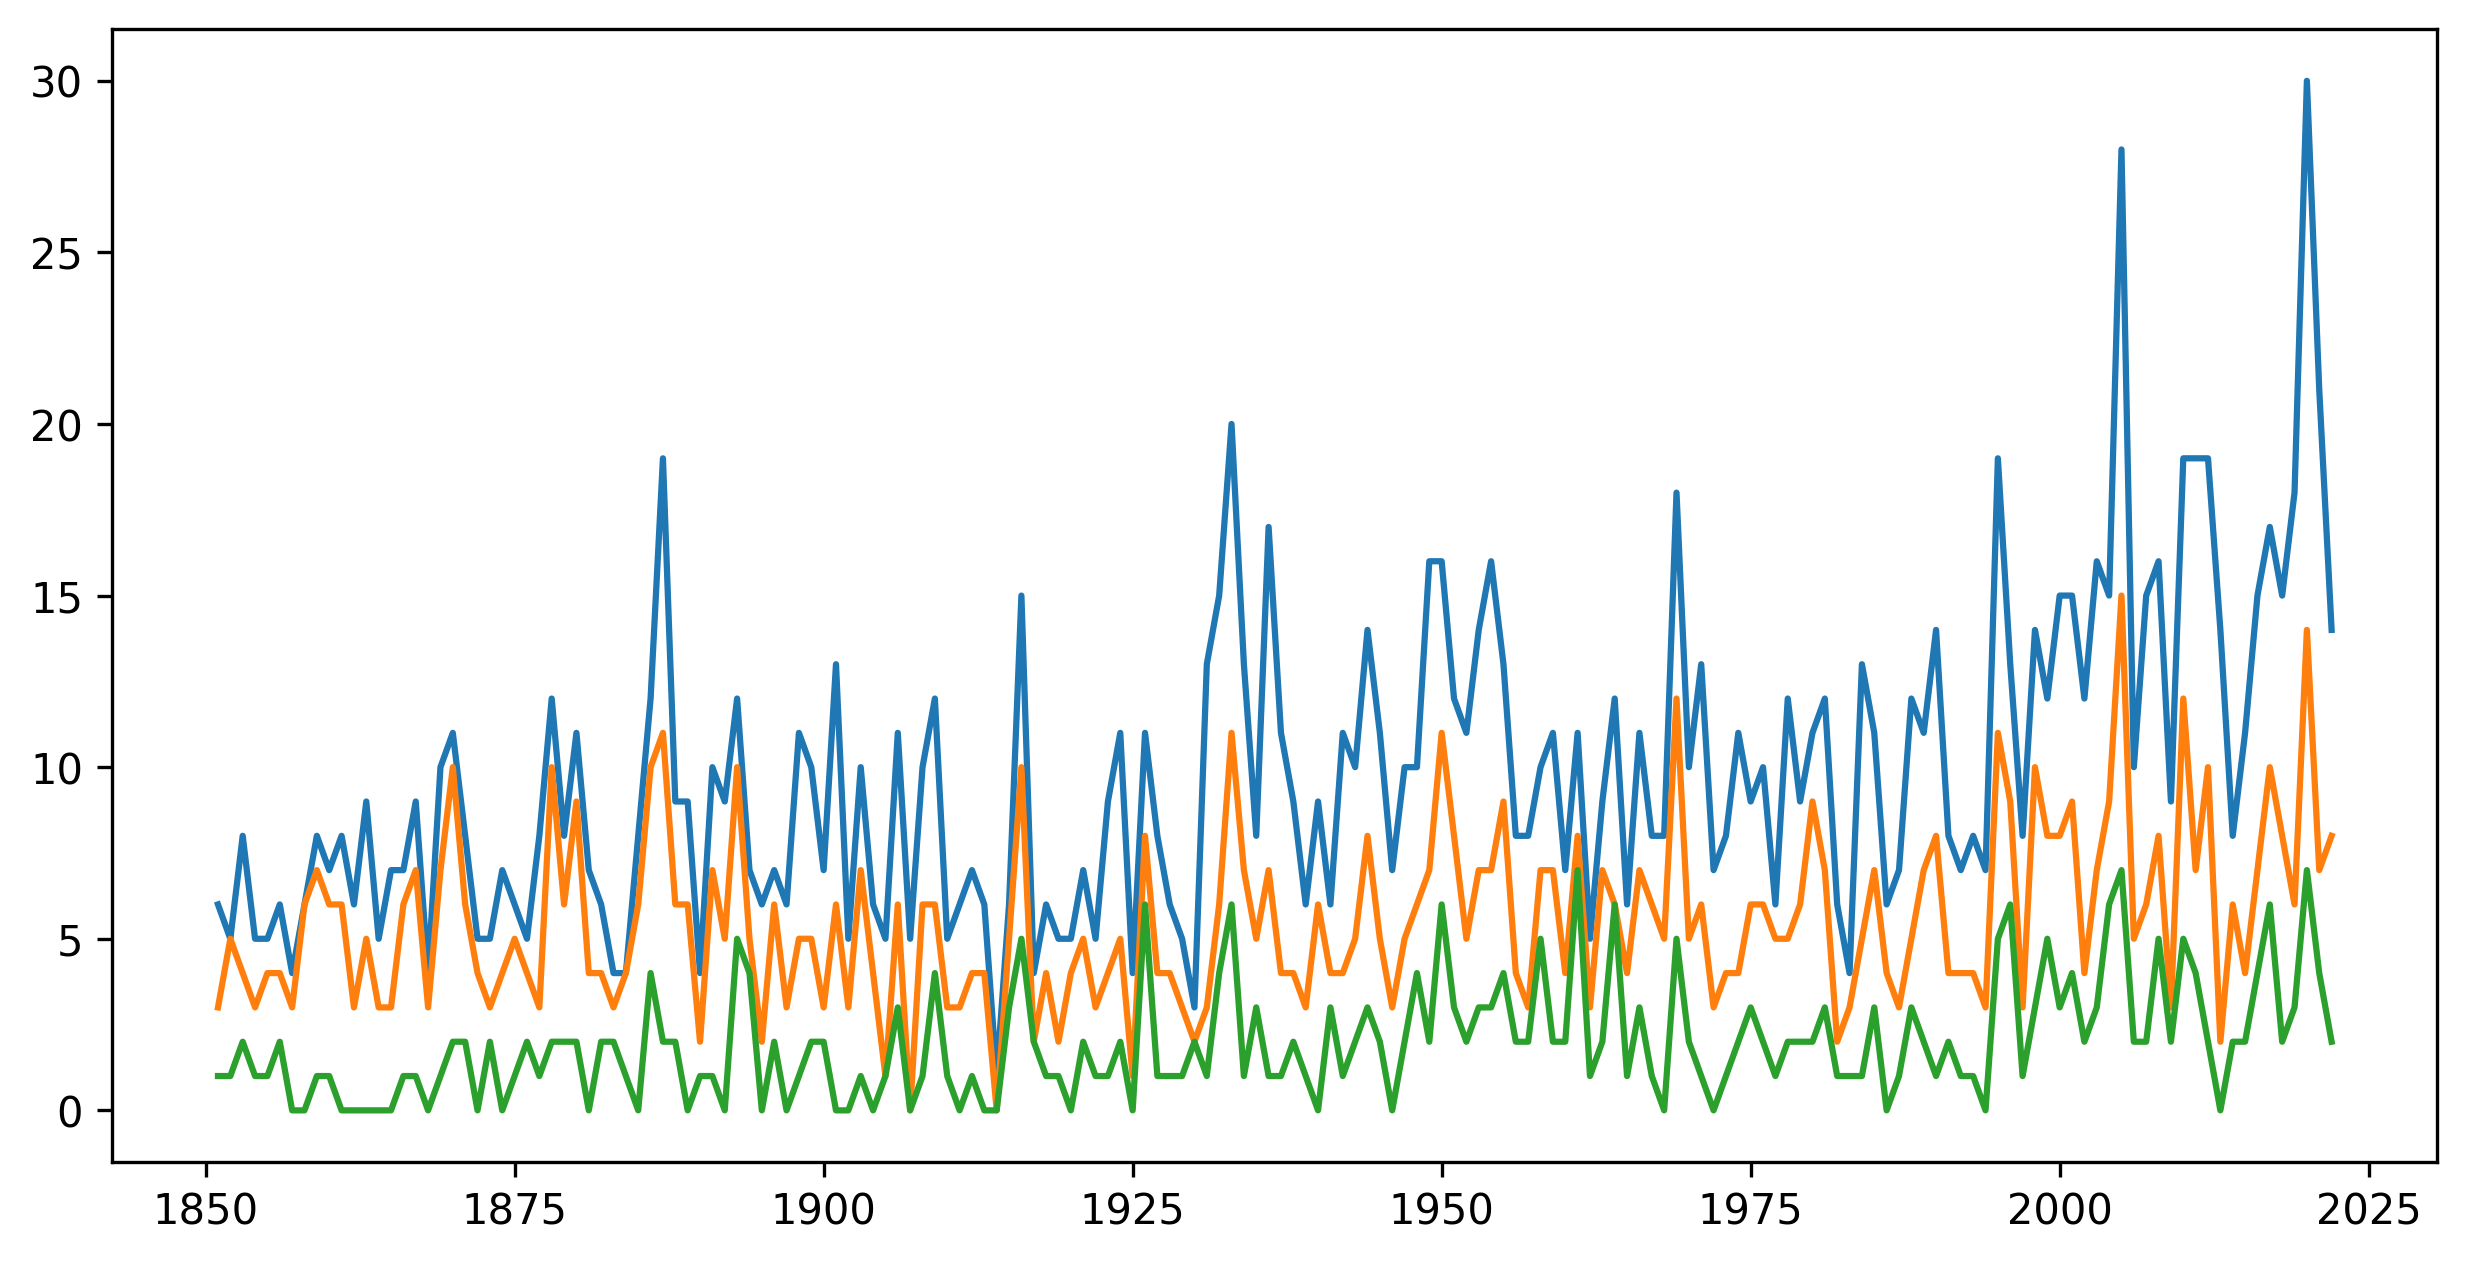

In [160]:
plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Tropical Storms")
plt.plot(df["Year"],df["Hurricanes"], label = "Hurricanes")
plt.plot(df["Year"],df["Major Hurricanes"], label = "Major Hurricanes")

## Functions:


### Climatology:

In [ ]:
def climatology_pred(df, start_year, end_year, window_length=30, variable="Tropical Storms"):

    predictions = []
    start_years = []
    end_years = []

    for year in range(start_year, end_year - (window_length - 1)):
        window = df[(df["Year"] >= year) & (df["Year"] < year + window_length)]
        prediction = window[variable].mean()
        predictions.append(prediction)
        start_years.append(year)
        end_years.append(year + (window_length - 1))

    return (predictions, start_years, end_years)


### Linear Regression:

In [162]:
def f(m,b,start,end):
    values = m*np.arange(start,end,1)+b
    return values

In [163]:
def linear_reg_pred(df,start_year,end_year,window_length = 30,variable = "Tropical Storms"):
    predictions = []
    start_years = []

    for year in range(start_year,end_year-(window_length-1)):
        window = df[(df["Year"] >= year) & (df["Year"] < year + window_length)]
        x = window["Year"].to_numpy().reshape((-1, 1))
        y = window[variable].to_numpy()
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        intercept = model.intercept_
        slope = model.coef_

        prediction = f(m = slope,b = intercept,start = year,end = 2025)
        predictions.append(prediction)
        start_years.append(year)
    
    return (predictions,start_years)

### Persistence:

In [178]:
def persistence_pred(df,start_year,end_year,window_length = 5,variable = "Tropical Storms"):
    predictions = []
    years = []

    for year in range(start_year,end_year):
        window = df[(df["Year"] >= year-window_length) & (df["Year"] < year)]
        pred = window[variable].mean()
        predictions.append(pred)
        years.append(year)
    
    return (predictions,years)

## Making Predictions:

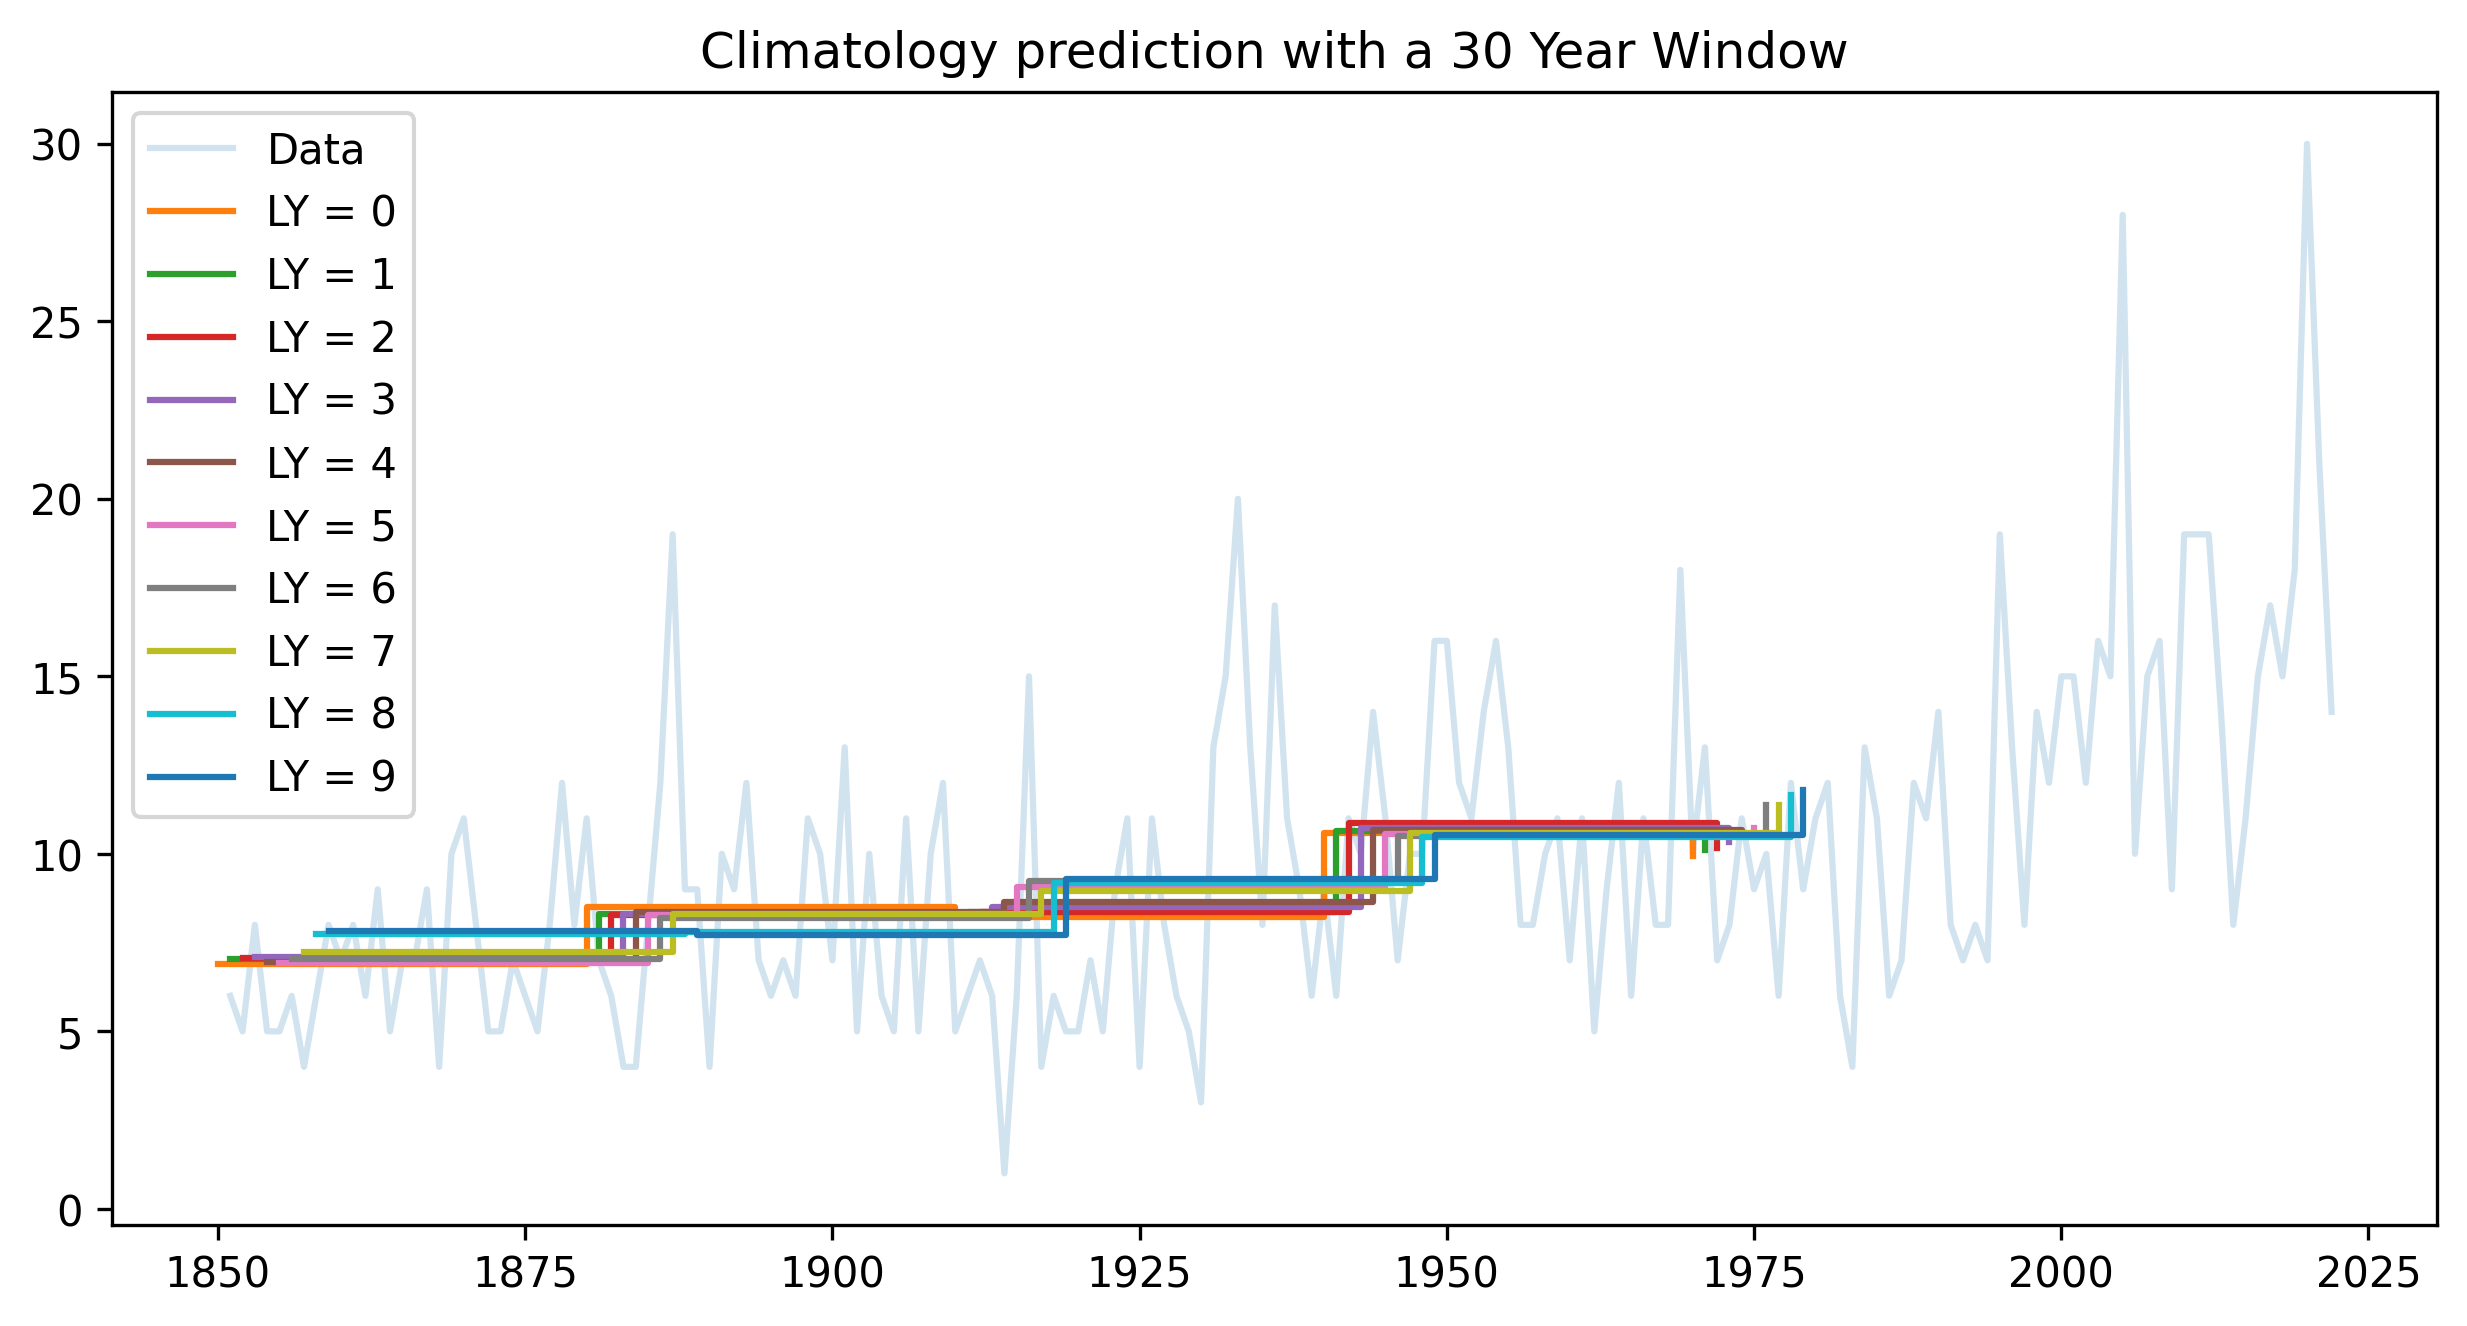

In [179]:
start_year = 1850
end_year = 2025
window_length = 30
num_ly = 10
predict,starts,ends = climatology_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.2)
#plt.plot(starts,predict)
for ly in range(num_ly):
    plt.plot(starts[ly::window_length], predict[ly::window_length], drawstyle='steps-post', label=f'LY = {ly}')
plt.legend(loc = "best")
plt.title(f"Climatology prediction with a {window_length} Year Window")
plt.savefig(f"plots/climatology_numly{num_ly}_window{window_length}.pdf")

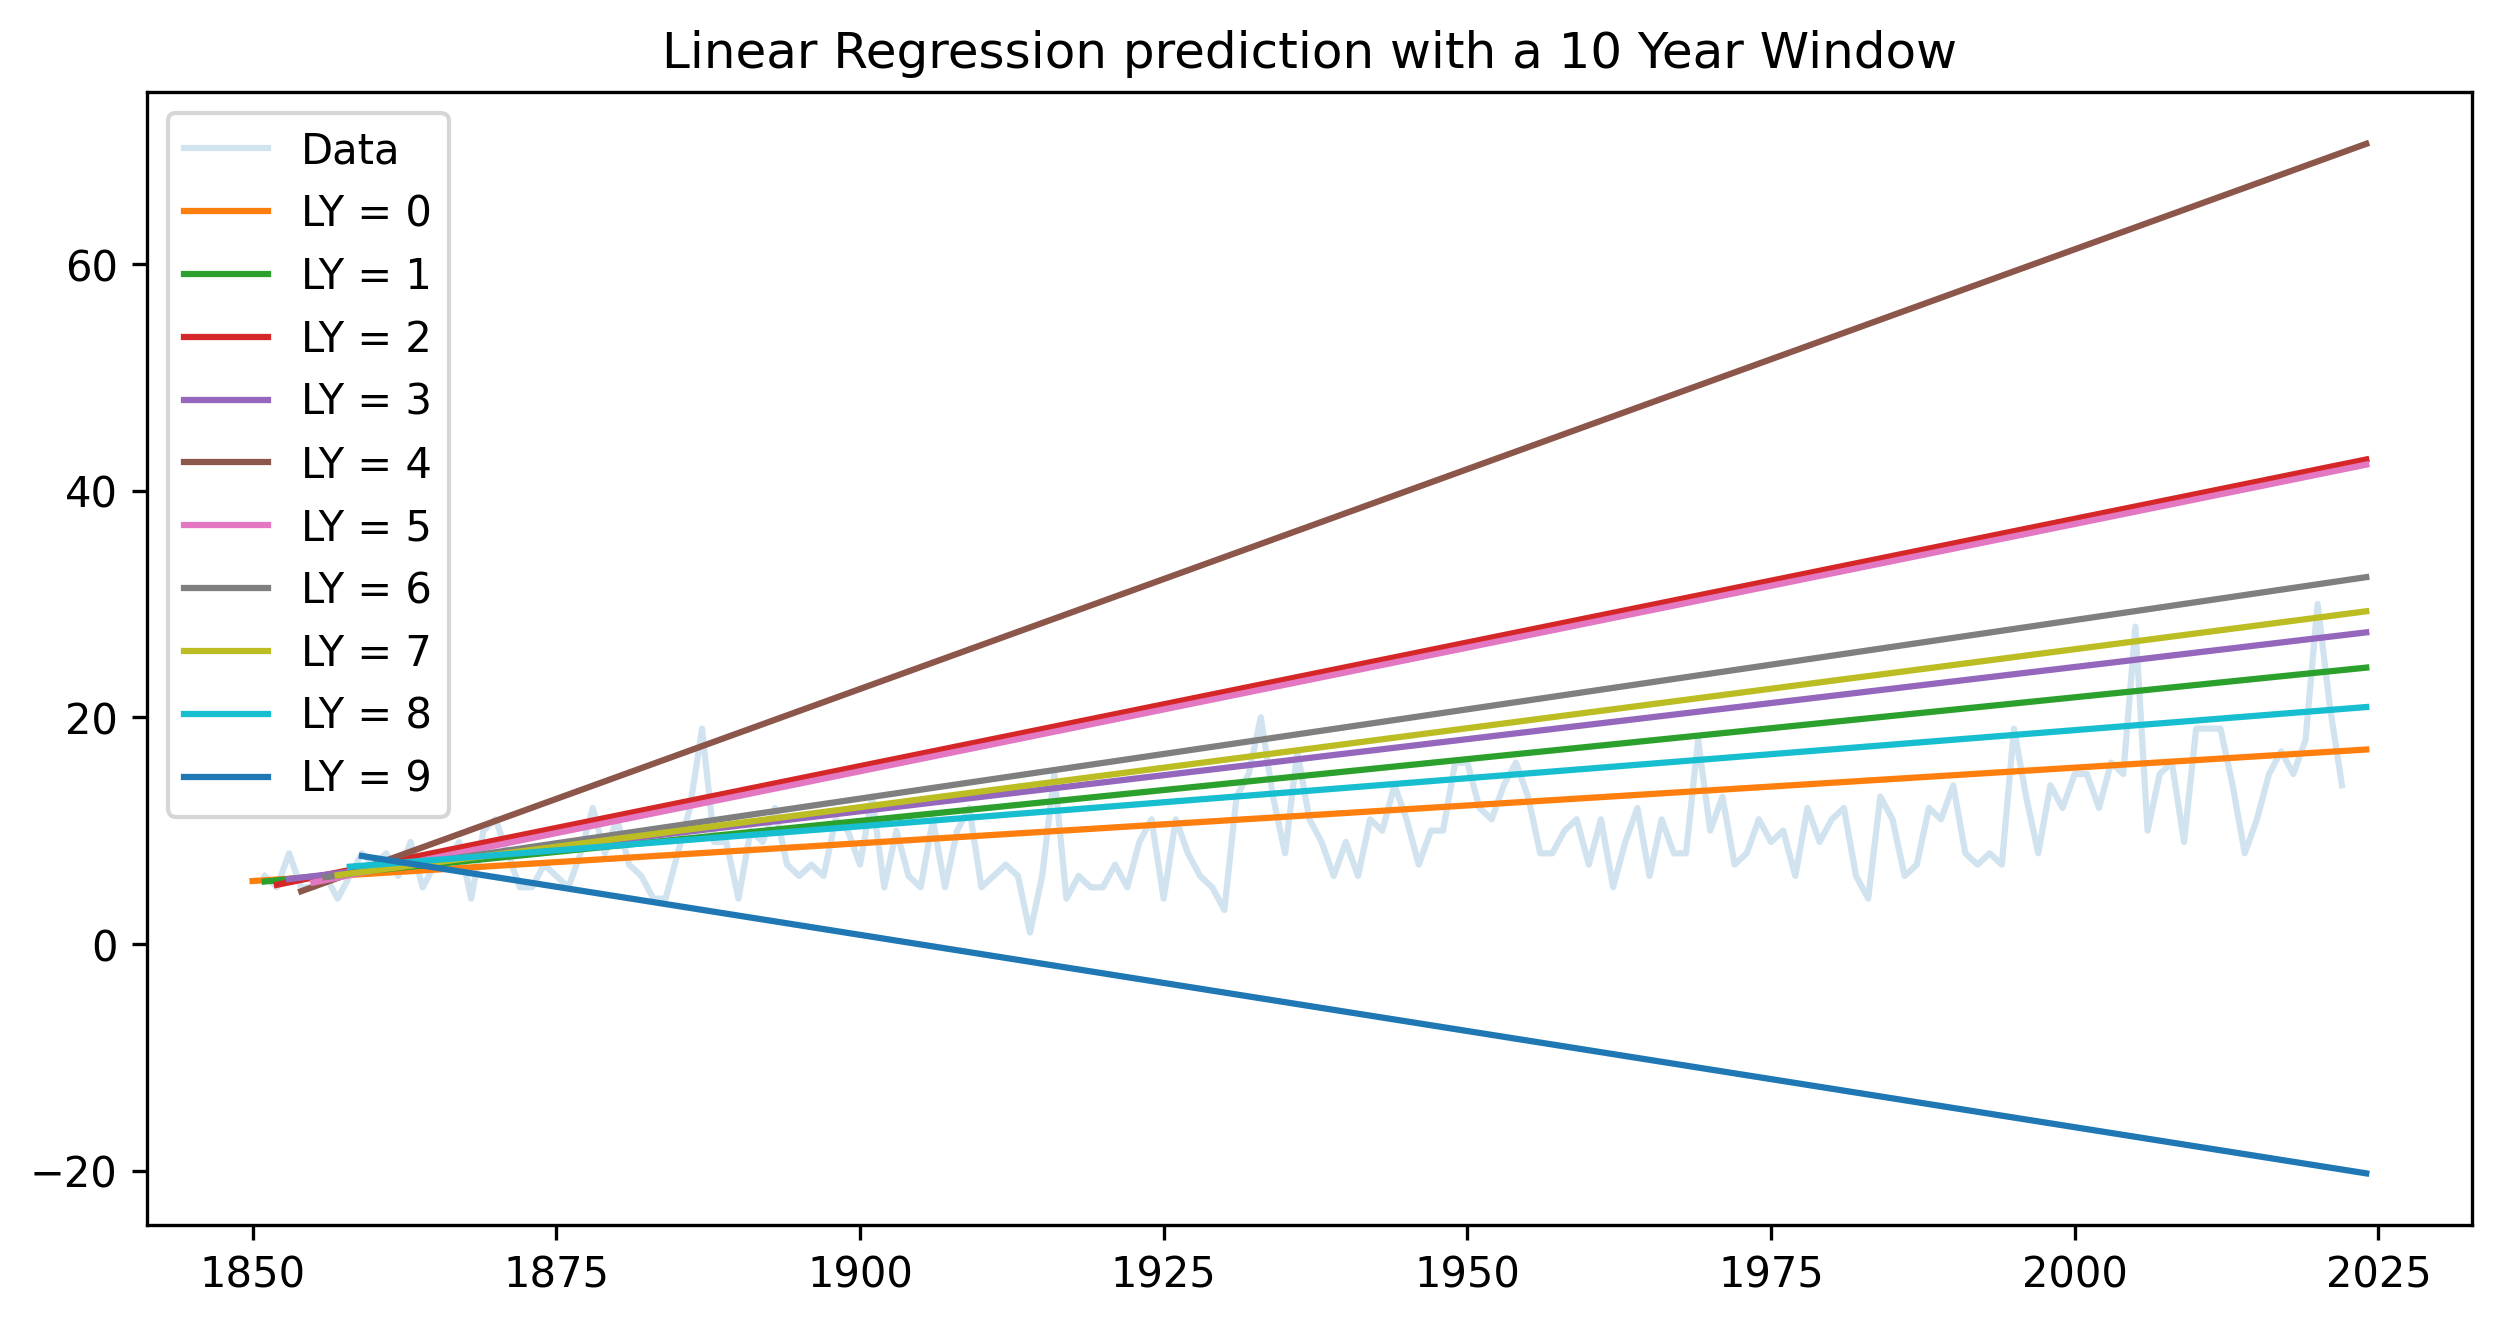

In [189]:
start_year = 1850
end_year = 2025
window_length = 10
num_ly = 10
predict,starts = linear_reg_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.2)
for ly in range(num_ly):
    plt.plot(np.arange(starts[ly],2025),predict[ly], label=f'LY = {ly}')
plt.legend(loc = "best")
plt.title(f"Linear Regression prediction with a {window_length} Year Window")
plt.savefig(f"plots/linear_reg_numly{num_ly}_window{window_length}.pdf")

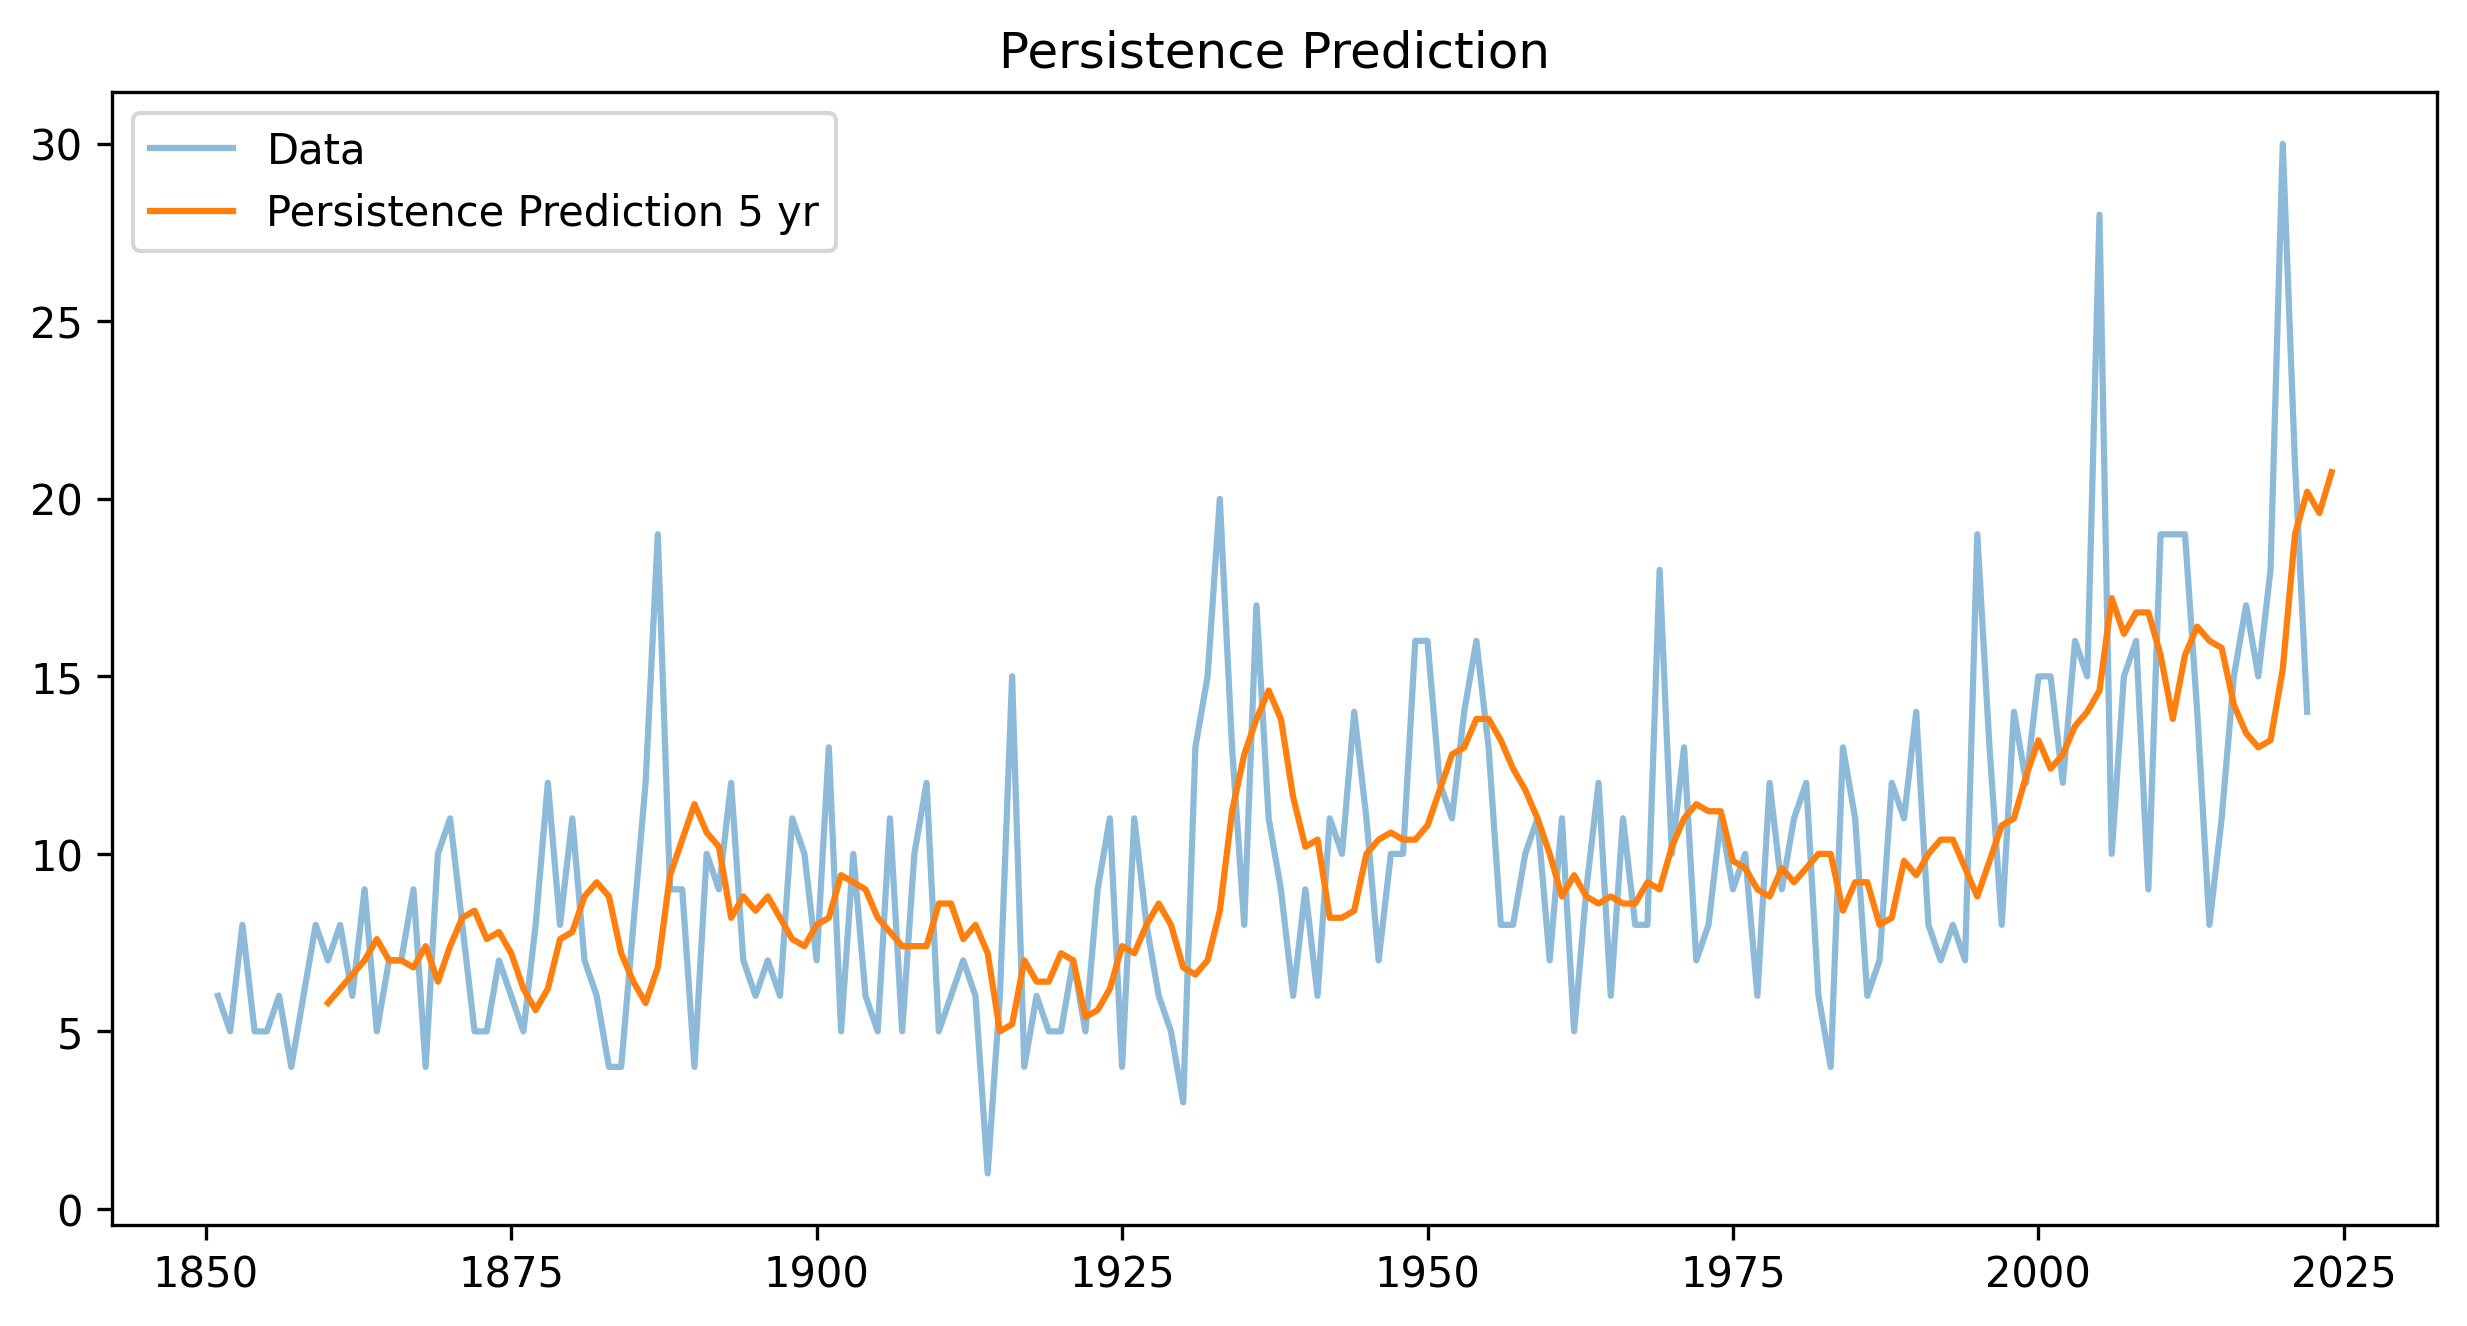

In [187]:
start_year = 1860
end_year = 2025
window_length = 5
#num_ly = 10
predict,years = persistence_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.5)
# for ly in range(num_ly):
#     plt.plot(np.arange(starts[ly],2025),predict[ly], label=f'LY = {ly}')
plt.plot(years,predict,label=f'Persistence Prediction {window_length} yr')
plt.legend(loc = "best")
plt.title(f"Persistence Prediction")
plt.savefig(f"plots/persistence_window{window_length}.pdf")